# Stroke Prediction

In [522]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import missingno as msno

from scipy.stats import shapiro

from scipy import stats
from scipy.stats import mannwhitneyu

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, precision_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import matthews_corrcoef
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.impute import KNNImputer
import seaborn as sns
import re
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans

import textblob
from unidecode import unidecode

pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [523]:
"""Setting graph parameters"""
sns.set_theme(style='whitegrid')
sns.set_palette('rocket')

In [524]:
%load_ext autoreload
%autoreload 2
from help_tool import help_tool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data download and Cleaning

Avg_glucose_level (mg/dL)

In [525]:
stroke_prediction=help_tool.csv_download(r"C:\Users\Gintare\Desktop\Study\Module3\Sprint2\Code\archive\healthcare-dataset-stroke-data.csv")
stroke_prediction.head()

,Id,Gender,Age,Hypertension,Heart_disease,Ever_married,Work_type,Residence_type,Avg_glucose_level,Bmi,Smoking_status,Stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [526]:
help_tool.first_look(stroke_prediction)

Column data types:
Id                     int64
Gender                object
Age                  float64
Hypertension           int64
Heart_disease          int64
Ever_married          object
Work_type             object
Residence_type        object
Avg_glucose_level    float64
Bmi                  float64
Smoking_status        object
Stroke                 int64
dtype: object

Dataset has 5110 observations and 12 features
Columns with NULL values: ['Bmi']
Dataset has 0 duplicates


* Dataset has 5110 observations and 12 features. Null values are in columns 'Bmi' (201 instances), no duplicates. 

In [527]:
stroke_prediction[stroke_prediction['Bmi'].isnull()].shape

(201, 12)

* Features have the expected datatypes, except age (which will be converted to interger)

In [528]:
stroke_prediction['Age']=stroke_prediction['Age'].astype(int)

Age, Avg_glucose_level and BMI are continuess features, while the rest are categorical

In [529]:
continues_features=['Age', 'Avg_glucose_level', 'Bmi']
category_features=['Gender', 'Hypertension', 'Heart_disease', 'Ever_married', 'Work_type', 'Residence_type', 'Smoking_status', 'Stroke']

In [530]:
stroke_data = stroke_prediction.copy()
stroke_data.drop(columns=['Id'], inplace=True)

help_tool.first_look(stroke_data)

Column data types:
Gender                object
Age                    int32
Hypertension           int64
Heart_disease          int64
Ever_married          object
Work_type             object
Residence_type        object
Avg_glucose_level    float64
Bmi                  float64
Smoking_status        object
Stroke                 int64
dtype: object

Dataset has 5110 observations and 11 features
Columns with NULL values: ['Bmi']
Dataset has 0 duplicates


## Continues features
Adults and children (up to 18 years old) have different ranking of BMI (Body Mass index). 
* [Children](https://dryatendrayadav.com/wp-content/uploads/2018/10/Sample-BMI-interpretation.jpg) BMI is generaly lower than adults and safe BMI is represented by a parabole. Healthy BMI by 10 years old is between 14 and 18.
* [Adults](https://blog.skinnyfit.com/wp-content/uploads/2021/01/shutterstock_1610175649-2048x2048.jpg) BMI is a constant - BMI between 19 AND 25 is denoted as safe. 

Due to children having different heath parameter levels than adults, data on < 18 years old will not be used. Target feature 'Stroke' has 2 rows for Children and model will not suffer.

In [531]:
stroke_data[(stroke_data['Age'] < 18) & (stroke_data['Stroke'] == 1)]

,Gender,Age,Hypertension,Heart_disease,Ever_married,Work_type,Residence_type,Avg_glucose_level,Bmi,Smoking_status,Stroke
162,Female,1,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,Female,14,0,0,No,children,Rural,57.93,30.9,Unknown,1


Children and teens make up 856/5110 instances, dropping these rows will be beneficial to the 'Stroke' model as comparing children and adults health is like comparring pears and apples.

In [532]:
stroke_data[(stroke_data['Age'] < 18)].shape

(856, 11)

In [533]:
# Dropping 'Age' < 18
stroke_data = stroke_data[stroke_data['Age'] >= 18]

### Continues feature distribution

Age


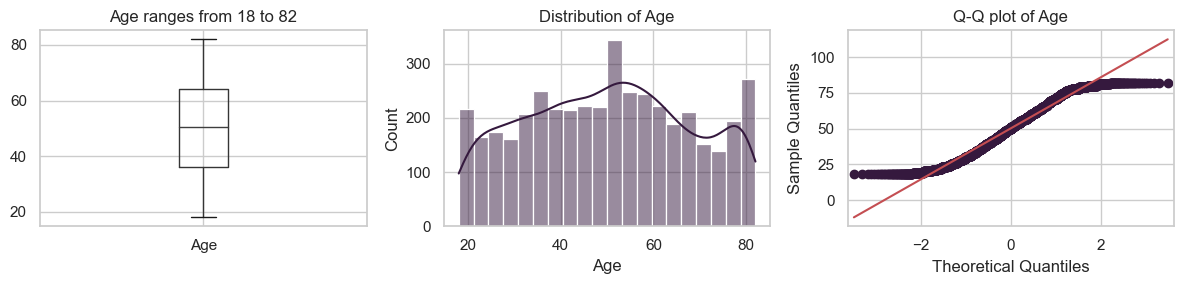

Avg_glucose_level


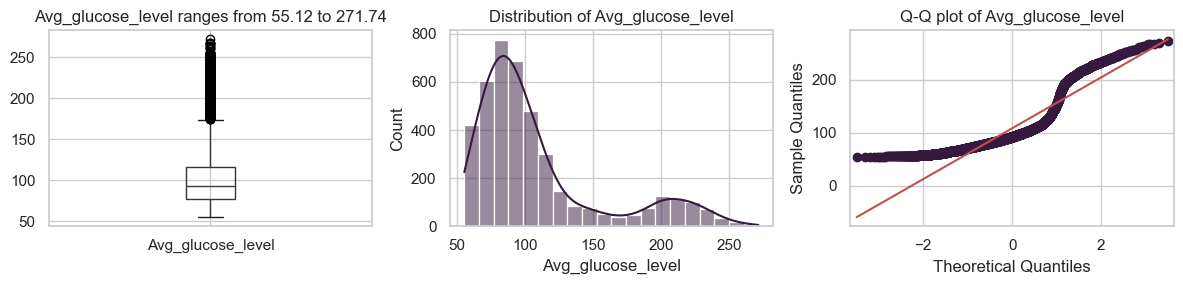

Bmi


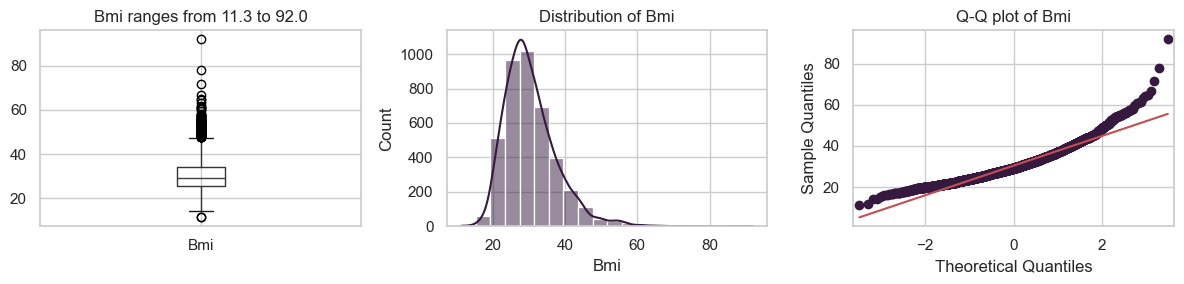

In [534]:
help_tool.distribution_check(stroke_data[continues_features])

Age, Avg_glucose_level and Bmi are non normally distributed - skewed to the right
* Age has the no outliers
* Avg_glucose_level is mostly around 50-100 (mg/dL), but it can go up above 240 (mg/dL) which signals dangerous glucose levels and medical attention would be needed due to [Hyperglycemia](https://www.mayoclinic.org/diseases-conditions/hyperglycemia/symptoms-causes/syc-20373631).

* Bmi reaches up to 100, according to [Wikipedia](https://en.wikipedia.org/wiki/List_of_heaviest_people), people can survive having 251 BMI . Outliers will be left in.

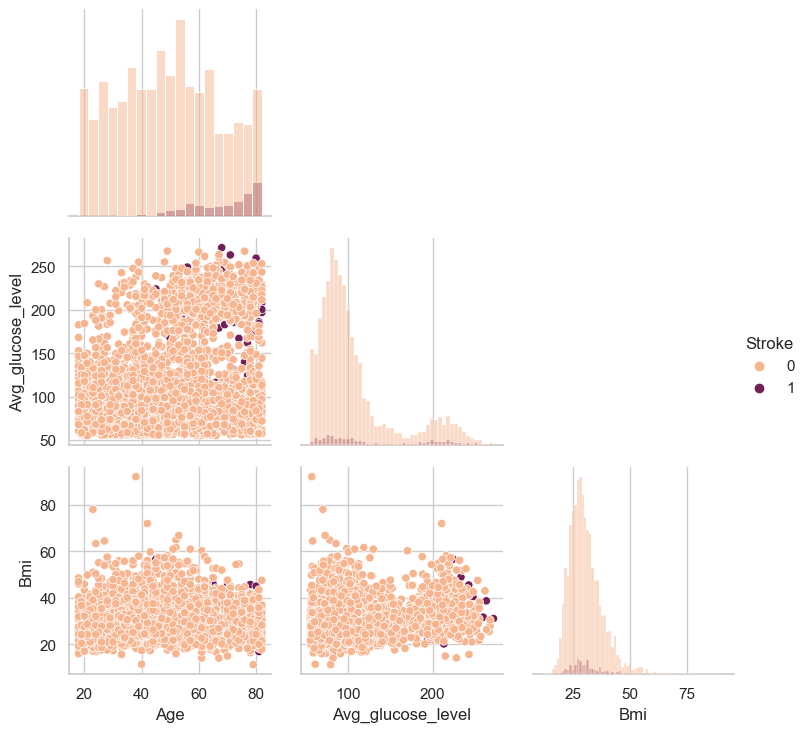

In [535]:
g = sns.PairGrid(stroke_data[continues_features+['Stroke']],
                 hue='Stroke',
                 diag_sharey=False, corner=True,
                 palette={1: 'C1', 0: 'C5'}
                 )
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

plt.show()

Categorical features look indipendent of one onother

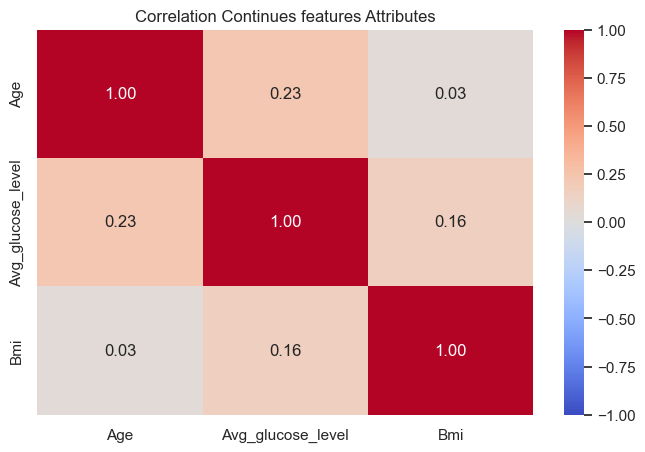

In [536]:
help_tool.heatmap(stroke_data[continues_features], 'Continues Features', 'pearson')

* Continues features are not linearly correlated.
* BMI has missing values but imputation will be performed at the last step of EDA (as the goal of imputation is to not change the distribution).

## Categorical features
Let's examine the distribution of categorical features

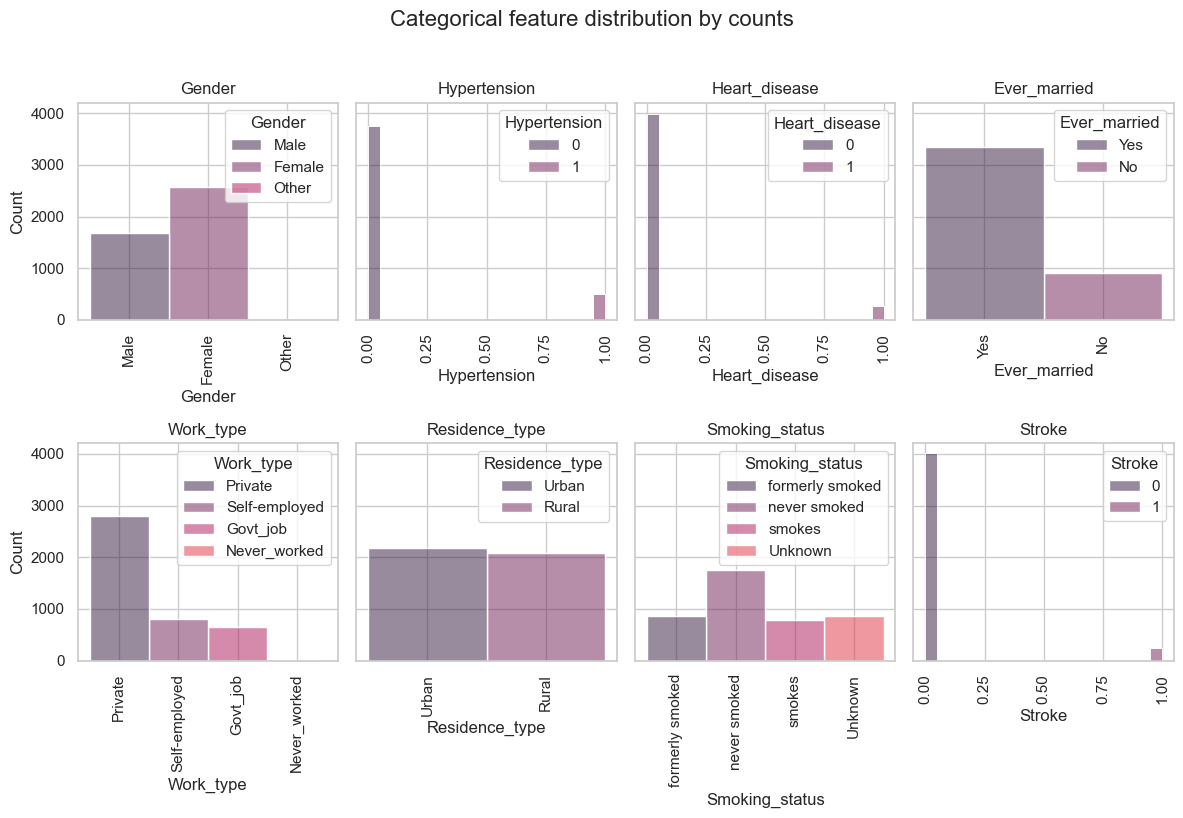

In [537]:
fig, axes = plt.subplots(2, 4, figsize=(12, 8), sharey=True)

axes = axes.flatten()

for i, col in enumerate(category_features):
    sns.histplot(data=stroke_data, x=col, kde=True, bins=20,
                    ax=axes[i], hue=col, legend=True)
    axes[i].set_title(col)  
    axes[i].tick_params(axis='x', rotation=90)  

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

In [538]:
stroke_prediction[stroke_prediction['Gender']=='Other'][['Gender', 'Stroke']]

,Gender,Stroke
3116,Other,0


* Target feature 'Stroke' is imbalanced, where '0' value is dominant.
* 'Gender' has 1 value outside Male/Female where target feature has dominant value - 1 row will be dropped as it won't significantly contribute to the model.
* Binary answers (Yes/No) anwers will be converted to binary features ('Gender', 'Ever_married', 'Residence_type').
* 'Work_type' and 'Smoking_status' will be examined further.

In [539]:
# Dropping 'Gender' = 'Other'
stroke_data = stroke_data[stroke_data['Gender'] != 'Other']


# Converting Binary answer features to 1/0
stroke_data = help_tool.dummy_columns(stroke_data, ['Gender', 'Ever_married', 'Residence_type'])
stroke_data.rename(columns={'Residence_type_Urban':'Residence_Urban'}, inplace=True)
stroke_data.drop(columns=['Gender_Male', 'Residence_type_Rural'], inplace=True)

### 'Work_type' Never Worked
Never worked individuals have 5 rows and all represent young people not yet entered to work force. These rows will be dropped as to reduce the upcomming model dimentionality.

In [540]:
stroke_data[stroke_data['Work_type'] == 'Never_worked']

,Age,Hypertension,Heart_disease,Work_type,Avg_glucose_level,Bmi,Smoking_status,Stroke,Gender_Female,Ever_married,Residence_Urban
603,23,0,0,Never_worked,125.26,18.7,never smoked,0,0,0,1
886,19,0,0,Never_worked,86.96,25.8,never smoked,0,1,0,1
2917,18,0,0,Never_worked,82.36,22.7,Unknown,0,1,0,1
4160,18,0,0,Never_worked,81.73,21.6,never smoked,0,1,0,1
4772,18,0,0,Never_worked,97.65,21.5,Unknown,0,1,0,1


In [541]:
stroke_data = stroke_data[stroke_data['Work_type'] != 'Never_worked']

In [542]:
stroke_data.shape

(4248, 11)

### Categorical feature distribution
Examining each binary variable to be a subset of another binary variable. I.e. Cat and Animal.

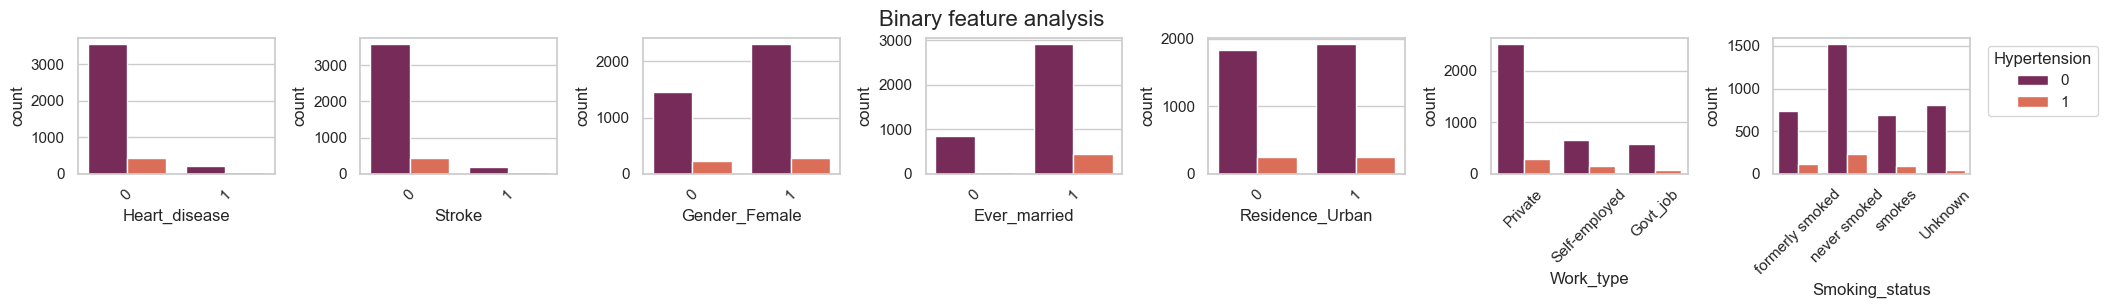

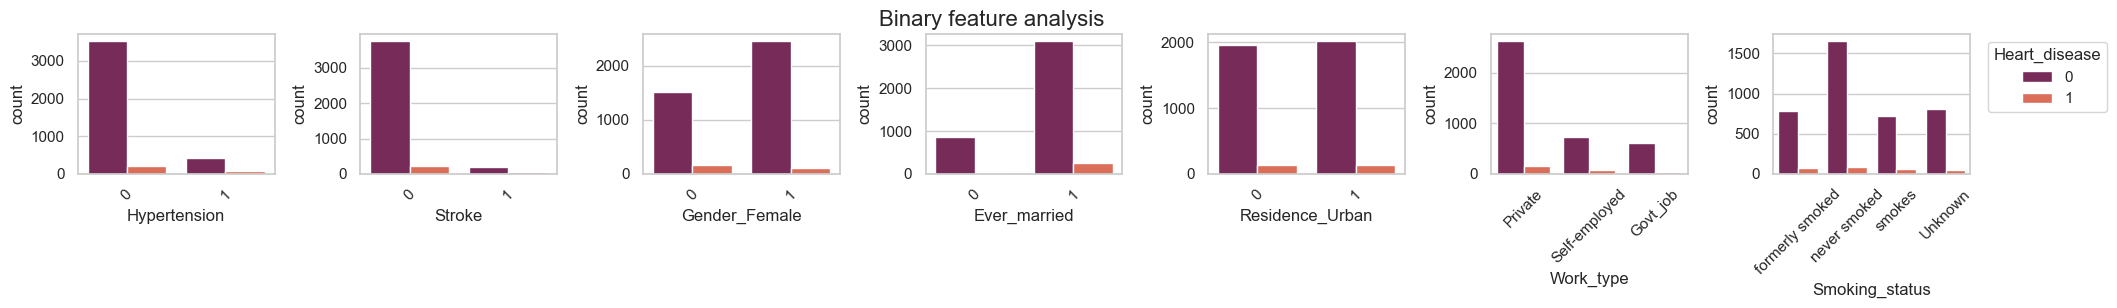

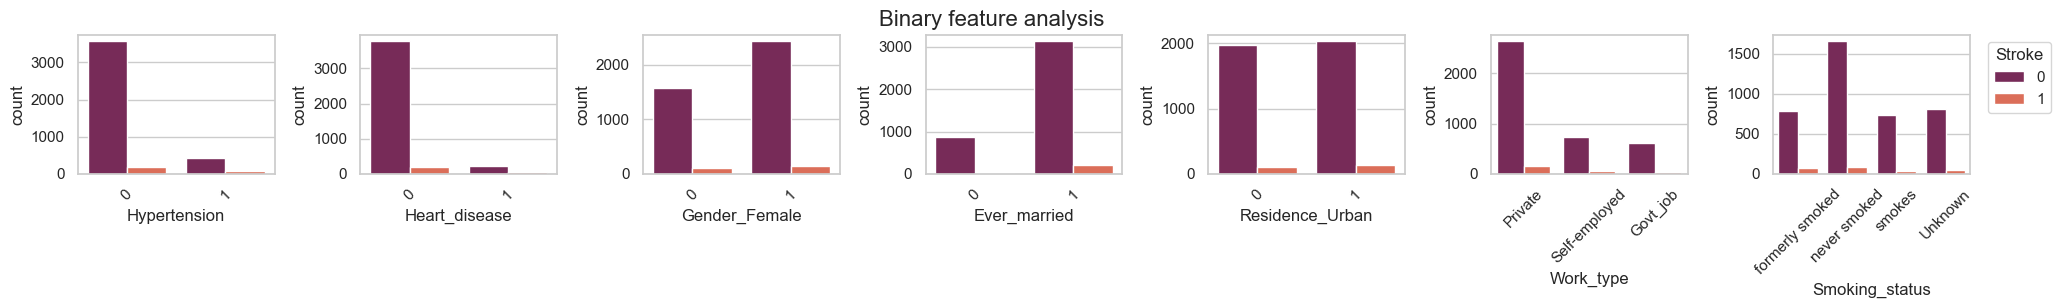

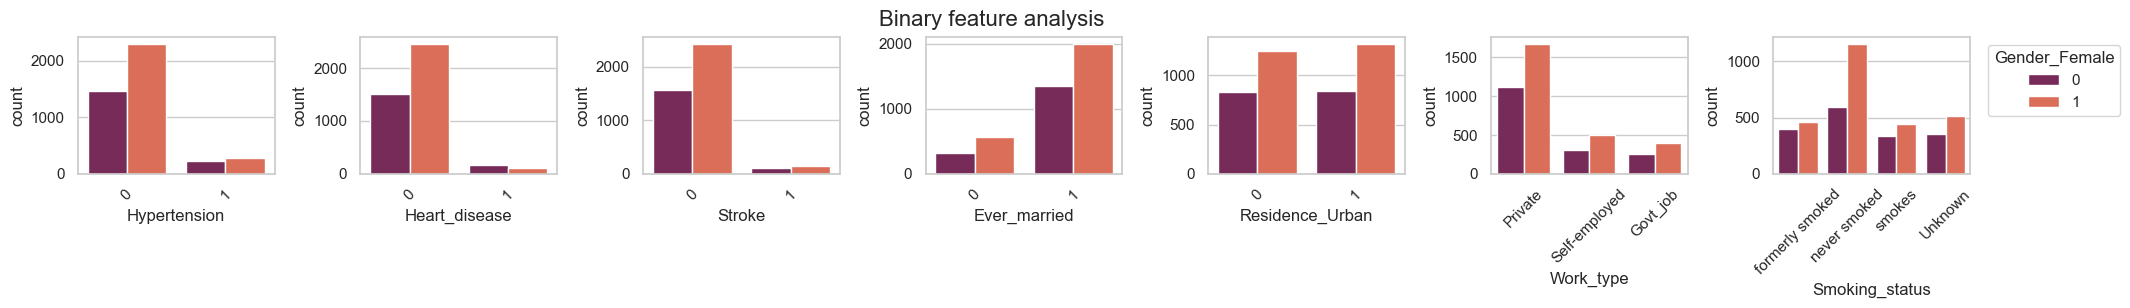

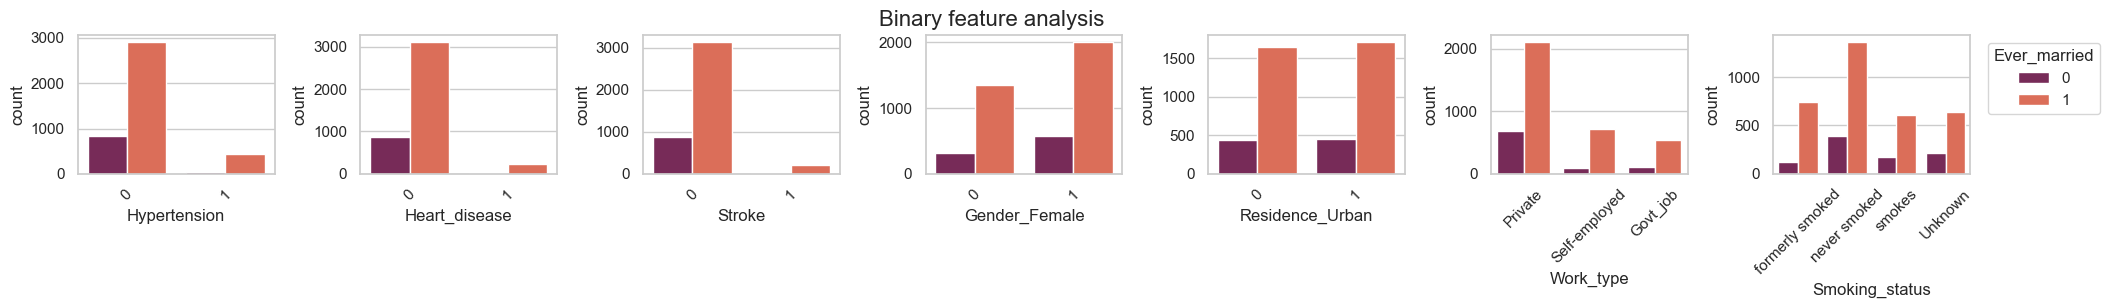

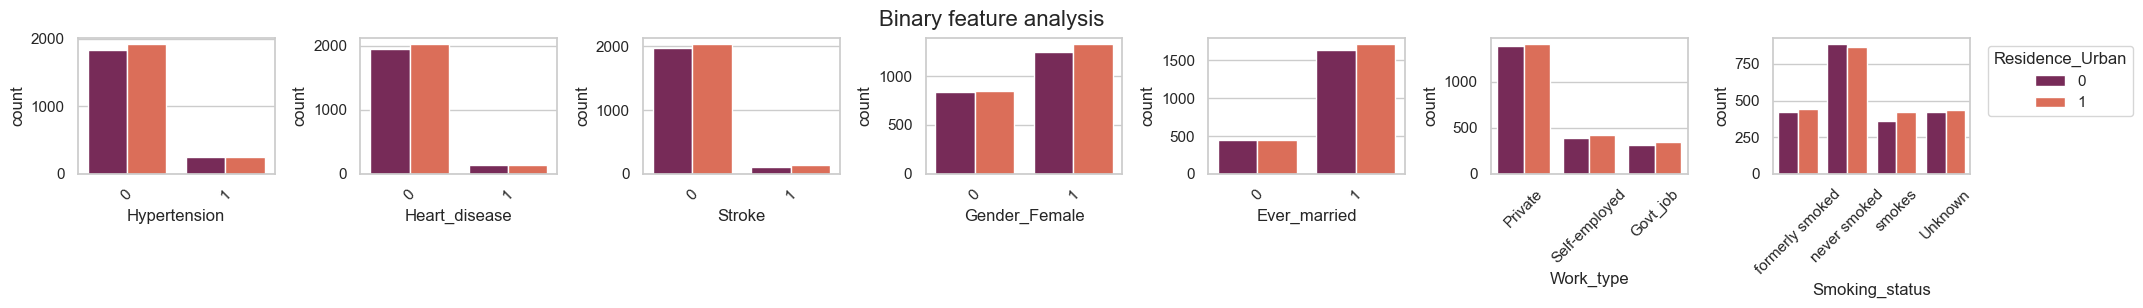

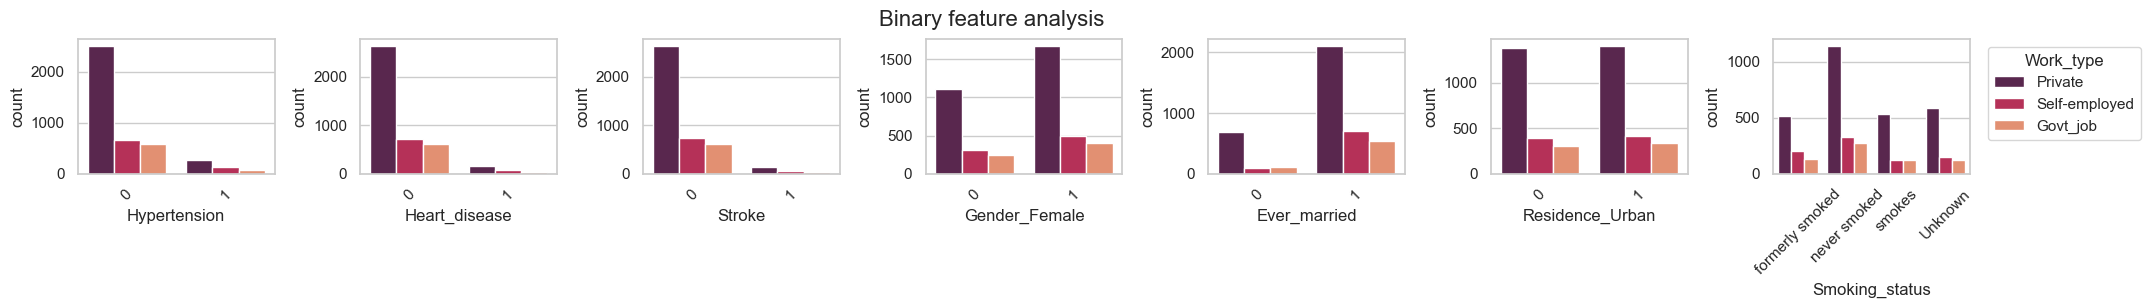

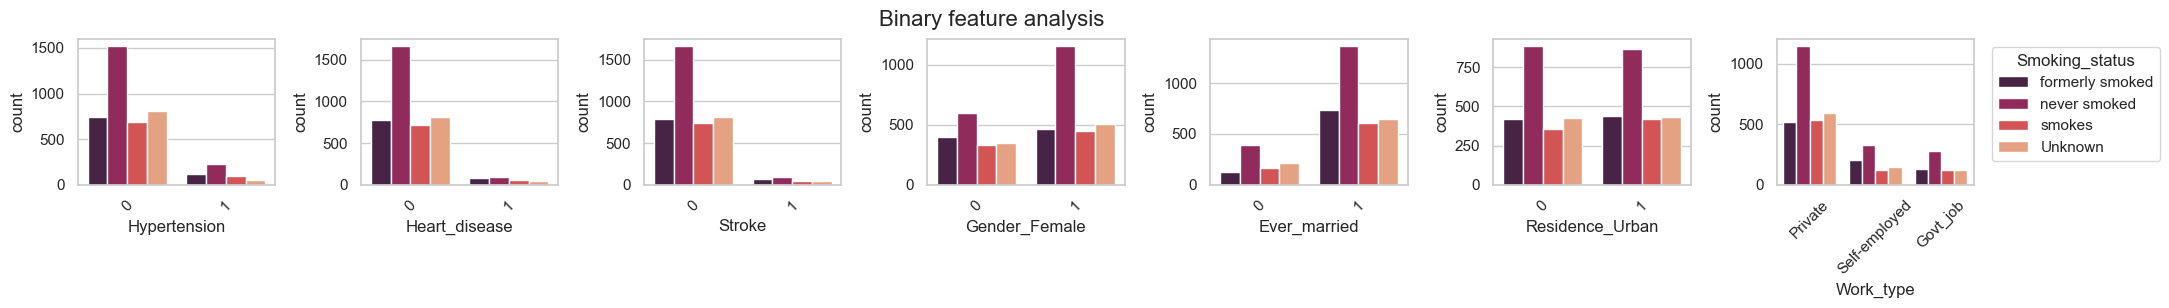

In [543]:
binary_features=['Hypertension', 'Heart_disease', 'Stroke', 'Gender_Female', 'Ever_married', 'Residence_Urban']

help_tool.countplot_per_feature(stroke_data, binary_features+['Work_type', 'Smoking_status'])

Ever_married stands out, it seams that never have been married have some dependency on never getting Heart_disease and Stroke. Another interpretation could be that young people are not married and diseases take up the body later in life.

In [544]:
print('Married: ')
help_tool.confidence_intervals(stroke_data[stroke_data['Ever_married'] == 1]['Age'], 'Continuous')
print('Never Married: ')
help_tool.confidence_intervals(stroke_data[stroke_data['Ever_married'] == 0]['Age'], 'Continuous')

Married: 
Confidence Interval: [53.82, 54.87]
Never Married: 
Confidence Interval: [33.75, 36.03]


Confidence intervals of 95% suggests that being married is a function of age. 

Null Hypothesis: Stroke and Heart_disease happens to any Age group.<br>
Alternative Hypotheses: Stroke and Heart_disease happening depends on Age groups.

In [545]:
for feature in ['Stroke', 'Heart_disease']:
    help_tool.significance_t_test(stroke_data, 'Age', feature, 0, 1)

p-value = 0.0000 between Age and Stroke. Reject null hypothesis
p-value = 0.0000 between Age and Heart_disease. Reject null hypothesis


Conclusion: Ever_married is dependent on age, same as Stroke and Heart_disease. The fact that never married people don't have diseases coincide with thos people being young.

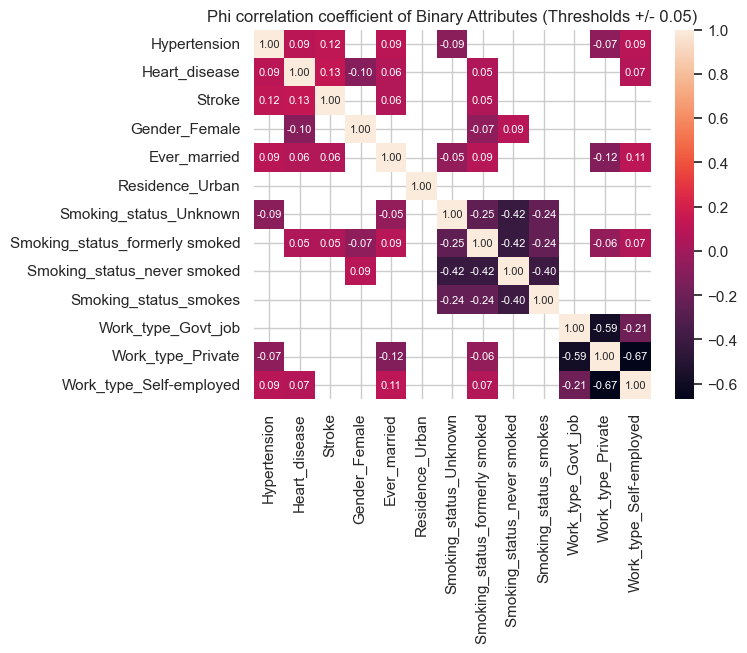

In [546]:
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Smoking_status', 'Work_type'])

dummy_features = ['Smoking_status_Unknown', 'Smoking_status_formerly smoked',
       'Smoking_status_never smoked', 'Smoking_status_smokes',
       'Work_type_Govt_job', 'Work_type_Private', 'Work_type_Self-employed']

help_tool.phi_corr_matrix(stroke_data_dummies, binary_features+dummy_features)

* Binary features are not correlated among each other

## All features

In [547]:
# g = sns.PairGrid(stroke_data,
#                  hue='Stroke',
#                  diag_sharey=False, corner=True,
#                  palette={1: 'C1', 0: 'C5'}
#                  )
# g.map_diag(sns.histplot)
# g.map_lower(sns.scatterplot)
# g.add_legend()

# plt.show()

In [548]:
# correlation_matrix = pd.DataFrame(
#     index=binary_features+dummy_features, columns=continues_features)

# for binary_feature in binary_features:
#     for continuous_feature in continues_features:
#         biserial_corr, _ = stats.pointbiserialr(
#             stroke_data_dummies[binary_feature], stroke_data_dummies[continuous_feature])
#         correlation_matrix.loc[binary_feature,
#                                continuous_feature] = biserial_corr

# for dummy_feature in dummy_features:
#     for continuous_feature in continues_features:
#         biserial_corr, _ = stats.pointbiserialr(
#             stroke_data_dummies[dummy_feature], stroke_data_dummies[continuous_feature])
#         correlation_matrix.loc[dummy_feature,
#                                continuous_feature] = biserial_corr

# correlation_matrix = correlation_matrix.apply(pd.to_numeric)

# sns.heatmap(pd.DataFrame(correlation_matrix), annot=True, cmap="rocket", fmt=".2f")
# plt.title("Biserial Correlation Heatmap")
# plt.show()

# Imputation
There's 3 main imputation methods
* Mean/Median/Mode Imputation: Replacing missing values with the Mean/Median/Mode for continuous/ordinal/categorical variables of the observed values in the same column.
* Regression Imputation: Using other variables in the dataset to predict the missing values of a continuous variable. A regression model is built, the predicted values from the regression model are then used to impute the missing values.
* K-Nearest Neighbors (KNN) Imputation.
## BMI and Smoking_status
* Since data is imbalanced and BMI distribution is skewed, KNN imputer was chosen.
* Smoking_status can have ordinal encoding ('never smoked': 0, 'formerly smoked': -1, 'smokes': 1) or mean encoding (mean being the most freaquent value 'never smoked'). Ordinal encoding with KNN imputer was chossen for more nuanced imputation.

In [549]:
stroke_data_dummies.shape

(4248, 16)

In [550]:
# Smoking_status
# Ordinal encoding for Smoking_status
stroke_data['Smoking_status'].replace({'Unknown': np.nan, 'never smoked': 0, 'formerly smoked': -1, 'smokes': 1}, inplace=True)

# Imputation with extension
stroke_data['Smoking_status_was_missing']=stroke_data['Smoking_status'].isnull().astype(int)


# BMI
# Imputation with extension for BMI
stroke_data['Bmi_was_missing']=stroke_data['Bmi'].isnull().astype(int)

In [551]:
# Rewriting stroke_data_dummies to fit the new structure
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])

In [552]:
# Scalling 0 to 1, as KNN is sensitive to neighbor distince
stroke_data_dummies['Age_rescaled'] = stroke_data_dummies['Age']/100
stroke_data_dummies['Avg_glucose_level_rescaled'] = stroke_data_dummies['Avg_glucose_level']/300
stroke_data_dummies['Bmi_rescaled'] = stroke_data_dummies['Bmi']/100

# Removing non-scalled features
def_imputation = stroke_data_dummies.drop(['Bmi', 'Avg_glucose_level', 'Age', 'Bmi_was_missing', 'Smoking_status_was_missing'], axis=1)


# KNNImputer for NaN values
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(def_imputation)
imputed_features = imputer.transform(def_imputation)
imputed_df = pd.DataFrame(imputed_features, columns=def_imputation.columns)


# Rescalling back BMI
imputed_df['Age'] = imputed_df['Age_rescaled']*100
imputed_df['Avg_glucose_level'] = imputed_df['Avg_glucose_level_rescaled']*300
imputed_df['Bmi'] = imputed_df['Bmi_rescaled']*100

In [553]:
imputed_df['Age'] = imputed_df['Age_rescaled']*100
imputed_df['Avg_glucose_level'] = imputed_df['Avg_glucose_level_rescaled']*100
stroke_data_dummies=imputed_df.drop(['Age_rescaled', 'Avg_glucose_level_rescaled', 'Bmi_rescaled'], axis=1)

In [554]:
# Reseting indexes as they got uneven after imputation
imputed_df.reset_index(drop=True, inplace=True)
stroke_data.reset_index(drop=True, inplace=True)

# Assigning new values
stroke_data['Bmi']=imputed_df['Bmi']
stroke_data['Smoking_status']=imputed_df['Smoking_status'].round().astype(int)

In [555]:
# Rewriting stroke_data_dummies to fit the new structure
stroke_data_dummies = help_tool.dummy_columns(stroke_data, ['Work_type'])

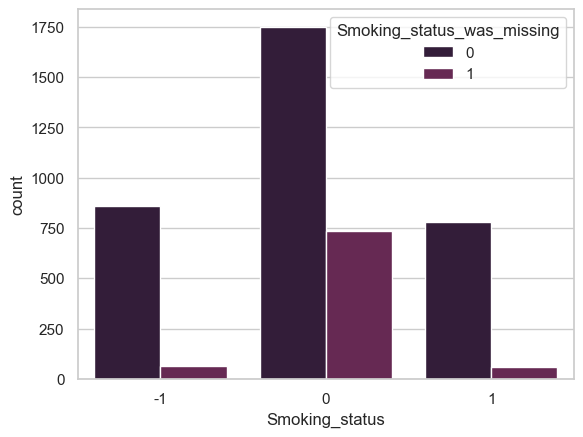

In [556]:
sns.countplot(data=stroke_data, x='Smoking_status', hue='Smoking_status_was_missing')
plt.show()

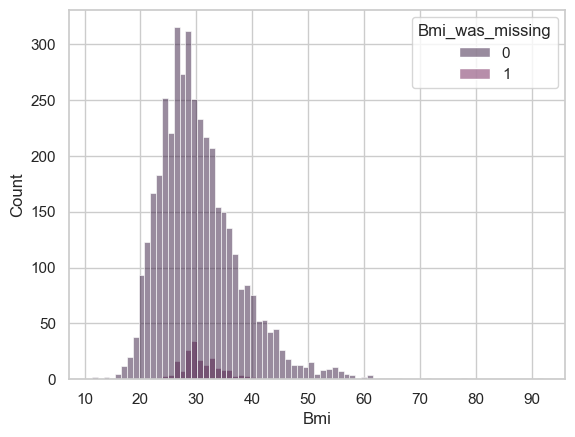

In [557]:
sns.histplot(data=stroke_data, x='Bmi', hue='Bmi_was_missing')
plt.show()

In [558]:
stroke_data.isna().sum()

Age                           0
Hypertension                  0
Heart_disease                 0
Work_type                     0
Avg_glucose_level             0
Bmi                           0
Smoking_status                0
Stroke                        0
Gender_Female                 0
Ever_married                  0
Residence_Urban               0
Smoking_status_was_missing    0
Bmi_was_missing               0
dtype: int64

# All features

In [559]:
dummy_features=['Work_type_Govt_job',
 'Work_type_Private',
 'Work_type_Self-employed', 'Smoking_status']

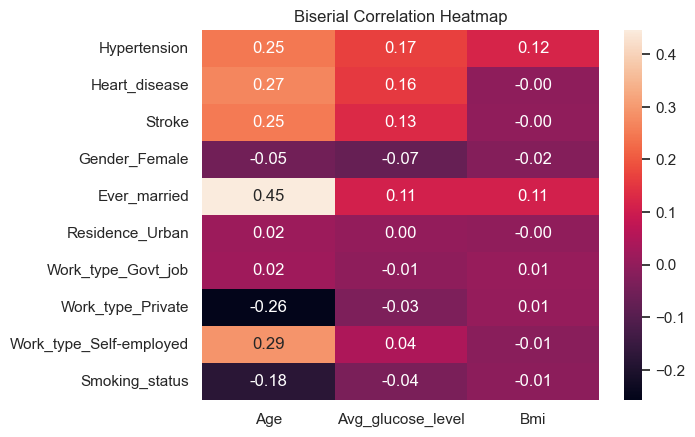

In [560]:
correlation_matrix = pd.DataFrame(index=binary_features+dummy_features, columns=continues_features)

for binary_feature in binary_features:
    for continuous_feature in continues_features:
        biserial_corr, _ = stats.pointbiserialr(
            stroke_data_dummies[binary_feature], stroke_data_dummies[continuous_feature])
        correlation_matrix.loc[binary_feature,
                               continuous_feature] = biserial_corr

for dummy_feature in dummy_features:
    for continuous_feature in continues_features:
        biserial_corr, _ = stats.pointbiserialr(
            stroke_data_dummies[dummy_feature], stroke_data_dummies[continuous_feature])
        correlation_matrix.loc[dummy_feature,
                               continuous_feature] = biserial_corr

correlation_matrix = correlation_matrix.apply(pd.to_numeric)

sns.heatmap(pd.DataFrame(correlation_matrix), annot=True, cmap="rocket", fmt=".2f")
plt.title("Biserial Correlation Heatmap")
plt.show()

# Fun
## Mutual information

In [561]:
stroke_data_rescalled=stroke_data_dummies

stroke_data_rescalled['Age'] = stroke_data_rescalled['Age']/100
stroke_data_rescalled['Avg_glucose_level'] = stroke_data_rescalled['Avg_glucose_level']/300
stroke_data_rescalled['Bmi'] = stroke_data_rescalled['Bmi']/100

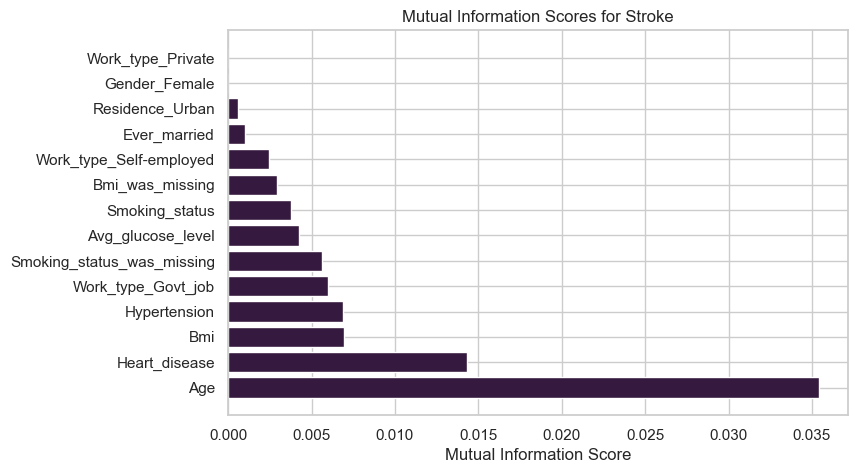

In [562]:
X = stroke_data_rescalled.drop('Stroke', axis=1)
y = stroke_data_rescalled['Stroke']

# Compute mutual information scores
mi_scores = pd.DataFrame(mutual_info_classif(X, y), index=X.columns, columns=['Mutual Information Gain'])
mi_scores.sort_values(by='Mutual Information Gain', ascending=False, inplace=True)

# Visualize the scores
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)

plt.figure(dpi=100, figsize=(8, 5))
plt.barh(width, mi_scores['Mutual Information Gain'])
plt.yticks(width, ticks)
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information Scores for Stroke")
plt.show()

## Clustering with K-means

In [563]:
X = stroke_data_rescalled.drop('Stroke', axis=1)
y = stroke_data_rescalled['Stroke']

In [564]:
from sklearn.cluster import KMeans

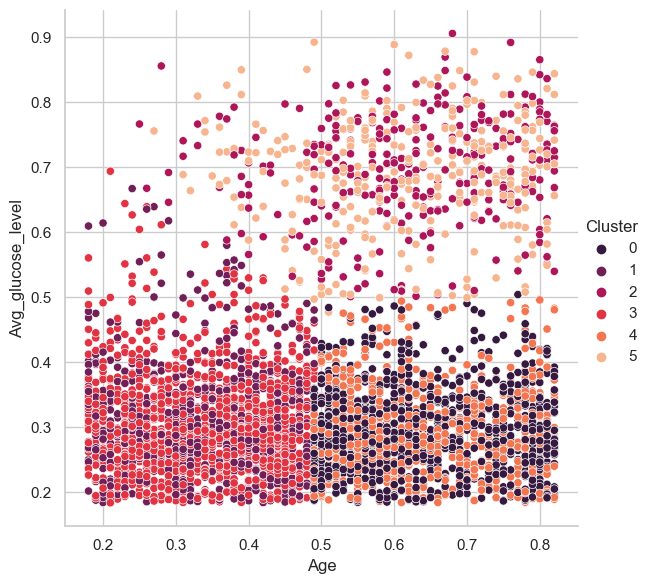

In [565]:
kmeans = KMeans(n_clusters=6, n_init=10)
X["Cluster"] = kmeans.fit_predict(X[['Age', 'Gender_Female', 'Avg_glucose_level', 
       'Bmi']])
X["Cluster"] = X["Cluster"].astype("category")

sns.relplot(data=X, x="Age", y="Avg_glucose_level", hue="Cluster", height=6,)
plt.show()

In [566]:
stroke_data['Gender_glucose_level']=X["Cluster"]

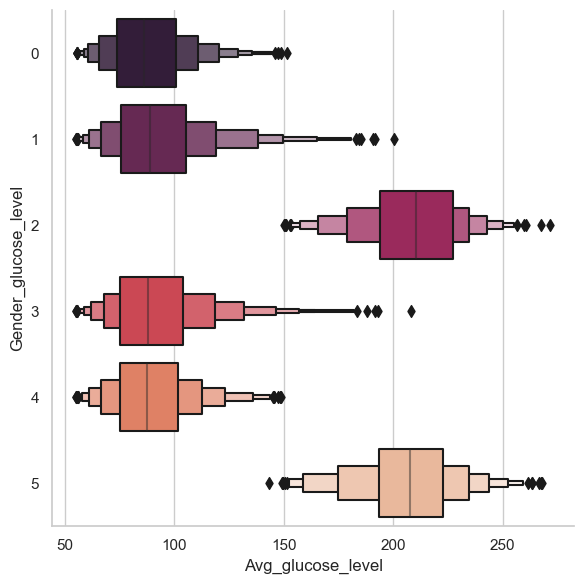

In [567]:
sns.catplot(data=stroke_data, x="Avg_glucose_level", y="Gender_glucose_level", kind="boxen", height=6)
plt.show()

## Principal Component Analysis
BMI and Age!

In [568]:
# # Create age groups
# bins = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00]
# labels = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
# stroke_data_dummies['Age'] = pd.cut(stroke_data_dummies['Age'], bins=bins, labels=labels, right=False)


In [569]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X
                          #[['Bmi', 'Age']]
                          )

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,-0.170537,0.868333,-0.626192,-0.434759,0.727357,-0.264015,-0.170764,0.028301,-0.011879,0.908442,-0.201538,0.204283,-0.239072,0.038668,1.452992e-15
1,2.758325,0.362195,0.888717,0.472349,-0.546247,-0.417247,0.389696,0.124725,-0.174906,0.109134,0.977847,0.125321,-0.073827,-0.065194,1.736678e-17
2,1.824029,-0.010402,-0.324033,0.589309,0.529766,-0.332506,-0.147891,-0.019046,-0.064125,0.878338,-0.229857,-0.077724,0.167246,0.035992,-6.043368e-16
3,2.793616,-1.047335,0.083323,-0.533261,-0.306066,-0.394361,-0.136811,-0.098461,-0.163659,-0.036963,-0.006106,0.152540,-0.038745,0.017212,3.486169e-16
4,2.758123,0.412495,0.954086,0.492769,-0.520061,-0.645963,0.329230,0.164501,0.661803,-0.257496,-0.080378,0.112784,0.070101,-0.097545,1.404321e-16


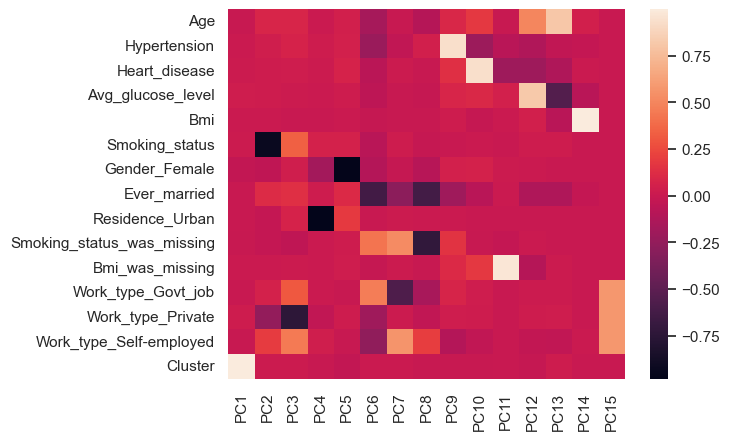

In [570]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings


sns.heatmap(loadings)
plt.show()

glucose and age for pc13

In [571]:
stroke_data_dummies

,Age,Hypertension,Heart_disease,Avg_glucose_level,Bmi,Smoking_status,Stroke,Gender_Female,Ever_married,Residence_Urban,Smoking_status_was_missing,Bmi_was_missing,Work_type_Govt_job,Work_type_Private,Work_type_Self-employed
0,0.67,0,1,0.762300,0.3660,-1,1,0,1,1,0,0,0,1,0
1,0.61,0,0,0.674033,0.2634,0,1,1,1,0,0,1,0,0,1
2,0.80,0,1,0.353067,0.3250,0,1,0,1,0,0,0,0,1,0
3,0.49,0,0,0.570767,0.3440,1,1,1,1,1,0,0,0,1,0
4,0.79,1,0,0.580400,0.2400,0,1,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,0.80,1,0,0.279167,0.2870,0,0,1,1,1,0,1,0,1,0
4244,0.81,0,0,0.417333,0.4000,0,0,1,1,1,0,0,0,0,1
4245,0.35,0,0,0.276633,0.3060,0,0,1,1,0,0,0,0,0,1
4246,0.51,0,0,0.554300,0.2560,-1,0,0,1,0,0,0,0,1,0


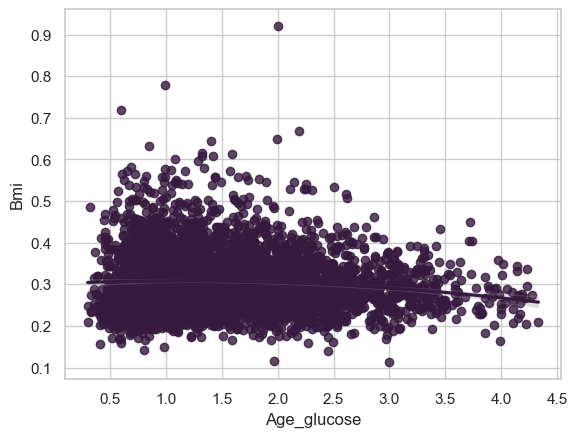

In [580]:
stroke_data_dummies['Age_glucose'] = stroke_data_dummies['Age'] / stroke_data_dummies['Avg_glucose_level']
sns.regplot(x='Age_glucose', y='Bmi', data=stroke_data_dummies, order=2)
plt.show()